# Plot LFRic Meshes at Differing Resolutions 

In this exercise you will plot the LFRic meshes at several resolutions (C12, C48 and C192) using the cartopy python package. 

The aim of the exercise is to explore LFRic's cubed sphere mesh, understand how it differs from the UM and explore how to plot it in python. 

This notebook contains a section for plotting global data followed by an exercise for plotting the mesh over specific countries.  

A lot of the examples are based from this source: https://pelson.github.io/2018/LFRic_containment/

Feel free to plot using other projections: 
https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

In [1]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import netCDF4 as nc  # noqa: N813
import numpy as np
from shapely import polygons
from shapely.geometry import GeometryCollection
from shapely.geometry.polygon import Polygon
from shapely.ops import transform
from shapely.prepared import prep


In [2]:
import warnings

# ignores some chatty cartopy warnings about missing projection information.
warnings.filterwarnings("ignore", message="Approximating coordinate system")

In [3]:
# mesh details stored in a netcdf and provided to the model at run time
# select either C12, C48 or C192
resolution = "C12"
# set location of data
datapath = "/home/vagrant/Tutorials/UMvn13.9/data/Task17/"

In [4]:
class UnknownResolutionError(Exception):
    """Exception for unknown lfric resolution."""


def load_mesh_data(res: str) -> nc.Dataset:
    """Load lfric mesh."""
    match resolution:
        case "C12":
            return nc.Dataset(datapath+"mesh_C12.nc")
        case "C48":
            return nc.Dataset(datapath+"mesh_C48_MG.nc")
        case "C192":
            return nc.Dataset(datapath+"mesh_C192_MG.nc")

    msg = f"Unkown Resolution: {res}, select one of C12, C48 or C192"
    raise UnknownResolutionError(msg)


In [5]:
def lfric_geoms(dataset: nc.Dataset) -> GeometryCollection:
    """
    From a mesh dataset construction a geometry collection of each face of
    the mesh's grid.

    Args:
        dataset (nc.Dataset): loaded in mesh netcdf.

    Returns:
        GeometryCollection: collection of polygon objects, one for each face
        of the mesh.

    """
    lons = np.asarray(dataset.variables["dynamics_node_x"][:])
    lats = np.asarray(dataset.variables["dynamics_node_y"][:])
    face_nodes = np.asarray(dataset.variables["dynamics_face_nodes"][:,:])

    try:
        start_index = dataset.variables["dynamics_face_nodes"].getncattr(
            "start_index")
    except AttributeError:
        start_index = 0

    face_nodes -= start_index
    coords = np.stack((lons[face_nodes], lats[face_nodes]), axis=-1)
    return GeometryCollection(polygons(coords))


In [6]:
# load in the mesh dataset
dataset = load_mesh_data(resolution)

# construct a GeometryCollection object from the dataset - faster at plotting
geoms = lfric_geoms(dataset)

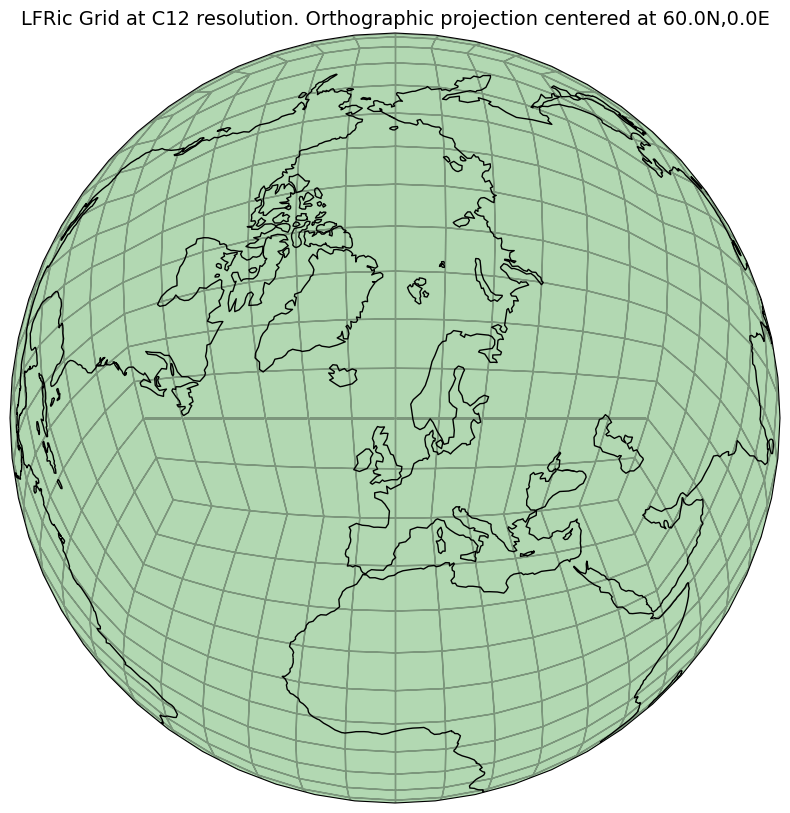

In [7]:
if resolution == "C192":
    print("WARNING - At C192 global plots can take a few mins to render")

center_lat = 60.0
center_lon = 0.0

fig = plt.figure(figsize=(10,10))
orth_proj = ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat)
ax = plt.axes(projection=orth_proj)
ax.add_geometries([geoms], ccrs.Geodetic(), facecolor="green",
                  edgecolor="k", alpha=0.3)
_ = ax.coastlines()

title = ax.set_title(f"LFRic Grid at {resolution} resolution. Orthographic projection centered at {center_lat}N,{center_lon}E", fontsize=14)


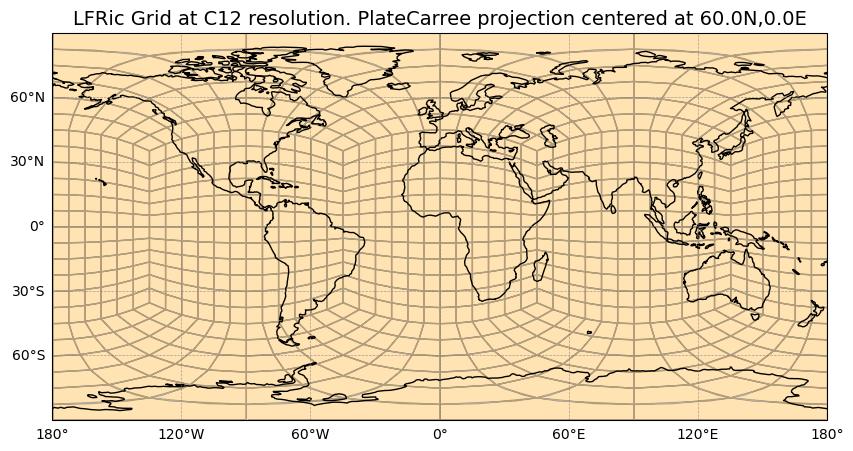

In [8]:
fig = plt.figure(figsize=(10,10))
pc_proj = ccrs.PlateCarree(central_longitude=0)
ax = plt.axes(projection=pc_proj)
ax.add_geometries(geoms, ccrs.Geodetic(),
                  facecolor="orange", edgecolor="k", alpha=0.3)
ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

title = ax.set_title(f"LFRic Grid at {resolution} resolution. PlateCarree"
                     f" projection centered at {center_lat}N,{center_lon}E",
                     fontsize=14)


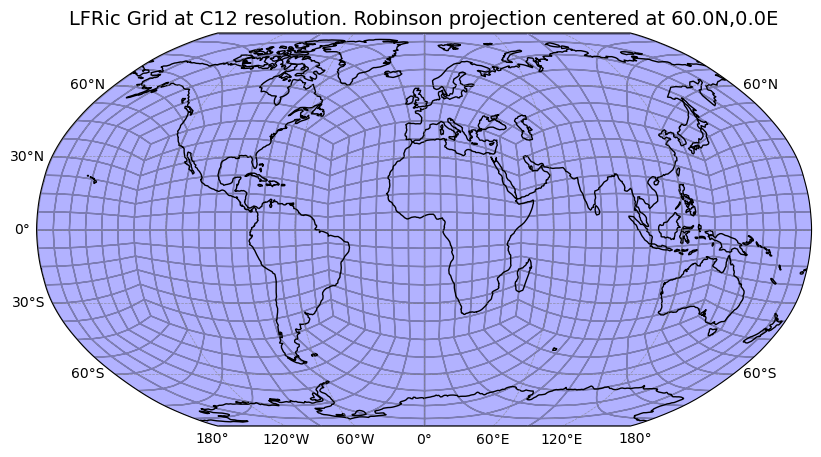

In [9]:
fig = plt.figure(figsize=(10,10))
pc_proj = ccrs.Robinson(central_longitude=0)
ax = plt.axes(projection=pc_proj)
ax.add_geometries(geoms, ccrs.Geodetic(),
                  facecolor="blue", edgecolor="k", alpha=0.3)
ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

title = ax.set_title(f"LFRic Grid at {resolution} resolution. Robinson "
                     f"projection centered at {center_lat}N,{center_lon}E",
                     fontsize=14)

## Filter points by country

Exercise: 
- how many data points cover the United Kingdom at each of the resolutions?
- plot the data points for Greenland at C192 resolution - what do you notice about the mesh cells and how would they differ from the Unified Model's mesh?

In [10]:
# user inputs
country_name = "Australia"

In [11]:
class CountryNotFoundError(Exception):
    """Exception for unknown country."""

In [12]:
# source the country admin boundaries from cartopy - it'll download locally
shpfilename = shpreader.natural_earth(
    resolution="50m", category="cultural", name="admin_0_countries")
countries = list(shpreader.Reader(shpfilename).records())

try:
    [country_borders] = [country for country in countries
                   if country.attributes["NAME"] == country_name]
except ValueError as exc:
    msg = f"No border found for {country_name}"
    raise CountryNotFoundError(msg) from exc
country_borders = country_borders.geometry
country_borders_prep = prep(country_borders)

# helpful later for centering plots
centroid_lon, centroid_lat = country_borders.centroid.coords[0]


In [13]:
# This notebook cell is to get around issues with the datetime, i.e. if you look at fiji

def is_dateline_artifact(cell):
    minx, _, maxx, _ = cell.bounds
    return (maxx - minx) > 180.0


def shift_to_0360(geom):
    return transform(lambda x, y: ((x + 360) % 360, y), geom)


mesh_geoms = [shift_to_0360(i) if is_dateline_artifact(i) else i for i in
              list(geoms.geoms)]

In [14]:
# use this to prevent grid cells that cross date line being included
if resolution == "C12":
    max_cell_area = 2000
else:
    max_cell_area = 200

country_borders_geoms = [cell for cell in mesh_geoms
    if country_borders_prep.intersects(cell) if cell.area < max_cell_area]

print(f"The number of mesh cells covering {country_name} is "
      f"{len(country_borders_geoms)}")

The number of mesh cells covering Australia is 29


In [15]:
def set_extent_from_geom(ax: plt.axes, geom: Polygon, buffer: float,
                         projection: ccrs.Projection):
    """Helpful function for setting plot extent to geom."""
    x0, y0, x1, y1 = geom.bounds

    # helps with date line
    if x1 - x0 > 320.0:
        x0 = min([i.bounds[0] % 360 for i in country_borders.geoms] +
                 [i.bounds[2] % 360 for i in country_borders.geoms])
        x1 = max([i.bounds[0] % 360 for i in country_borders.geoms] +
                 [i.bounds[2] % 360 for i in country_borders.geoms])

    x1 += buffer
    x0 -= buffer
    y0 -= buffer
    y1 += buffer

    y0 = max(y0, -90.0)
    y1 = min(y1, 90.0)

    ax.set_extent([x0, x1, y0, y1], projection)

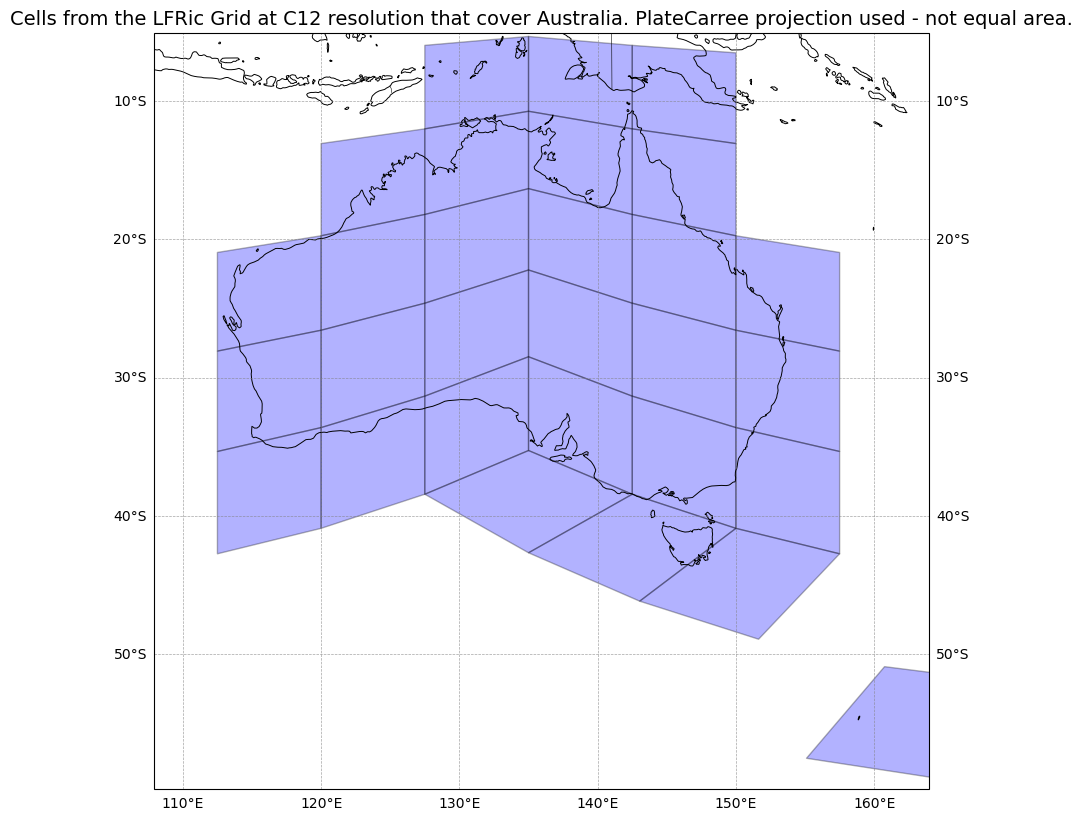

In [16]:
# increase this if some points are outside plotting region
plotting_buffer = 5

# PlateCarree projection is not equal area
plt.figure(figsize=(10, 10))
pc_proj = ccrs.PlateCarree(central_longitude=centroid_lon)
ax = plt.axes(projection=pc_proj)
ax.add_geometries(country_borders_geoms, ccrs.Geodetic(), facecolor="blue",
                  edgecolor="k", alpha=0.3)
ax.coastlines(resolution="50m", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
 
# note passing pc_proj results in poor extent
set_extent_from_geom(ax, country_borders, plotting_buffer, ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = True
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

title = ax.set_title(f"Cells from the LFRic Grid at {resolution} resolution "
                     f"that cover {country_name}. PlateCarree "
                     f"projection used - not equal area.",
                     fontsize=14)

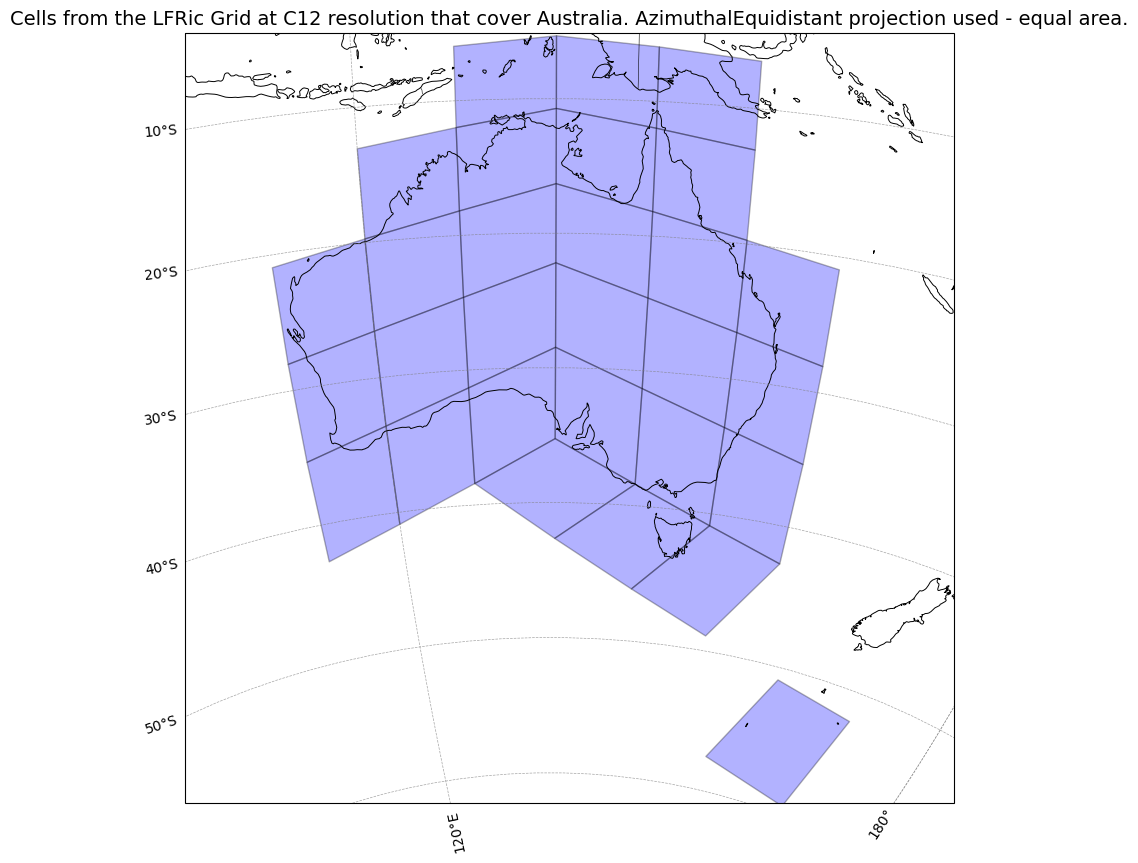

In [17]:
# increase this if some points are outside plotting region
plotting_buffer = 5

# AzimuthalEquidistant projection is equal area
plt.figure(figsize=(10, 10))
azi_proj = ccrs.AzimuthalEquidistant(central_longitude=centroid_lon,
                                    central_latitude=centroid_lat)
ax = plt.axes(projection=azi_proj)
ax.add_geometries(country_borders_geoms, ccrs.Geodetic(), facecolor="blue",
                  edgecolor="k", alpha=0.3)
ax.coastlines(resolution="50m", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

set_extent_from_geom(ax, country_borders, plotting_buffer, ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

title = ax.set_title(f"Cells from the LFRic Grid at {resolution} resolution "
                     f"that cover {country_name}. AzimuthalEquidistant "
                     f"projection used - equal area.",
                     fontsize=14)

***Written by Rob Waters, 2025***